# Waitlist survival analysis

By Zihao Guo 21/09/2022

# Feature selection

In [296]:
import copy
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
df_train = pd.read_excel("SimData_WList_Ver2.0.xls", index_col = False, header=0)
le = LabelEncoder()
df_train["Gender"] = le.fit_transform(df_train["Gender"])
df_train["Bloodtype"] = le.fit_transform(df_train["Bloodtype"])
#df_train["Donor_Bloodtype"] = le.fit_transform(df_train["Donor_Bloodtype"])
df_train["Inpt_attx"] = le.fit_transform(df_train["Inpt_attx"])
#df_train["Donor_Sex"] = le.fit_transform(df_train["Donor_Sex"])
#df_train["Donor_DCD"] = le.fit_transform(df_train["Donor_DCD"])
feature_df_train = copy.deepcopy(df_train)

In [125]:
y_time = feature_df_train['Time']
y_cens = feature_df_train['Cens']
feature_df_train = df_train.drop(['Time', 'Cens'], axis=1)

In [126]:
mytype=np.dtype([('Status', '?'), ('Survival_in_days', '<f8')])
data_y = np.zeros(5000,dtype=mytype)
for i in range(len(y_time)):
    data_y[i][0] = y_cens[i]
    data_y[i][1] = y_time[i]
data_y

array([(False, 6905.80632199), (False, 4583.03535097),
       (False, 2434.09076562), ..., ( True,  798.96020549),
       (False, 5284.05961066), (False, 1296.42344833)],
      dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

In [127]:
import numpy as np
from sksurv.metrics import concordance_index_censored
from sksurv.nonparametric import kaplan_meier_estimator
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(feature_df_train, data_y)

CoxPHSurvivalAnalysis()

In [128]:
pd.Series(estimator.coef_, index=feature_df_train.columns)

Gender      -0.045703
Bloodtype    0.048908
Inpt_attx    0.016669
Age          0.009284
BMI         -0.006228
MELD        -0.083442
MELDNA       0.145586
dtype: float64

In [129]:
from sksurv.metrics import concordance_index_censored # c index

prediction = estimator.predict(feature_df_train)
result = concordance_index_censored(data_y["Status"], data_y["Survival_in_days"], prediction)
result[0]

0.743402856021342

In [83]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(feature_df_train.values, data_y)
pd.Series(scores, index=feature_df_train.columns).sort_values(ascending=False)

MELDNA       0.735142
MELD         0.697335
Inpt_attx    0.604430
Gender       0.535016
Bloodtype    0.513241
Age          0.504986
BMI          0.499358
dtype: float64

In [84]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline


pipe = Pipeline([('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis())])

from sklearn.model_selection import GridSearchCV, KFold

param_grid = {'select__k': np.arange(1, feature_df_train.shape[1] + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(feature_df_train, data_y)

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]

,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
1,2,{'select__k': 2},0.743340,0.697401,0.769781,0.736841,0.029904,1,0.736169,0.759337,0.724316,0.739941,0.014544
4,5,{'select__k': 5},0.742039,0.700602,0.767366,0.736669,0.027519,2,0.739164,0.759475,0.726836,0.741825,0.013457
2,3,{'select__k': 3},0.743463,0.697122,0.769180,0.736588,0.029817,3,0.736148,0.759381,0.724392,0.739974,0.014538
3,4,{'select__k': 4},0.743364,0.696991,0.769222,0.736526,0.029882,4,0.736441,0.759407,0.724383,0.740077,0.014528
5,6,{'select__k': 6},0.741571,0.698105,0.767169,0.735615,0.028508,5,0.739049,0.762434,0.726826,0.742770,0.014773
6,7,{'select__k': 7},0.738846,0.697036,0.768209,0.734697,0.029204,6,0.743160,0.763001,0.727000,0.744387,0.014723
0,1,{'select__k': 1},0.745010,0.694272,0.759461,0.732914,0.027954,7,0.729835,0.752784,0.721210,0.734609,0.013325


# Cox Time

In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxTime
from pycox.models import CoxCC
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv


In [253]:
df_train = pd.read_excel("SimData_WList_Ver2.0.xls", index_col = False, header=0)

In [254]:
df_train

,Gender,Bloodtype,Inpt_attx,Age,BMI,MELD,MELDNA,Time,Cens
0,Female,A,home,42.980695,24.281426,11.328118,8.490318,6905.806322,0
1,Male,O,inpt,43.194412,30.097404,15.295122,20.956402,4583.035351,0
2,Male,A,home,44.952546,30.445467,20.222330,28.063602,2434.090766,0
3,Male,B,home,48.929001,22.588535,16.742302,19.049439,946.529267,0
4,Male,B,home,52.098949,18.317275,19.038291,21.116394,1606.310627,0
...,...,...,...,...,...,...,...,...,...
4995,Male,O,home,61.664413,31.271787,18.259893,21.114819,1790.328790,0
4996,Male,O,home,75.972972,32.058615,20.185605,18.230574,115.020774,0
4997,Female,O,home,46.186842,29.661992,16.680831,25.907240,798.960205,1
4998,Male,O,home,51.977156,18.661174,16.390241,25.747759,5284.059611,0


In [255]:
for i in range(len(df_train["Cens"])):
    if df_train["Cens"][i] == 1:
        if df_train.iloc[i,7] >= 12000:
            print(df_train.iloc[i])
            #print(i)
            

In [256]:
df_train.iloc[3681]

Gender               Male
Bloodtype               A
Inpt_attx            home
Age             47.285801
BMI             29.470271
MELD             14.74246
MELDNA          13.915993
Time         21558.498266
Cens                    0
Name: 3681, dtype: object

In [257]:
le = LabelEncoder()
df_train["Gender"] = le.fit_transform(df_train["Gender"])
df_train["Bloodtype"] = le.fit_transform(df_train["Bloodtype"])
#df_train["Donor_Bloodtype"] = le.fit_transform(df_train["Donor_Bloodtype"])
df_train["Inpt_attx"] = le.fit_transform(df_train["Inpt_attx"])
#df_train["Donor_Sex"] = le.fit_transform(df_train["Donor_Sex"])
#df_train["Donor_DCD"] = le.fit_transform(df_train["Donor_DCD"])

In [258]:
df_train

,Gender,Bloodtype,Inpt_attx,Age,BMI,MELD,MELDNA,Time,Cens
0,0,0,0,42.980695,24.281426,11.328118,8.490318,6905.806322,0
1,1,3,2,43.194412,30.097404,15.295122,20.956402,4583.035351,0
2,1,0,0,44.952546,30.445467,20.222330,28.063602,2434.090766,0
3,1,2,0,48.929001,22.588535,16.742302,19.049439,946.529267,0
4,1,2,0,52.098949,18.317275,19.038291,21.116394,1606.310627,0
...,...,...,...,...,...,...,...,...,...
4995,1,3,0,61.664413,31.271787,18.259893,21.114819,1790.328790,0
4996,1,3,0,75.972972,32.058615,20.185605,18.230574,115.020774,0
4997,0,3,0,46.186842,29.661992,16.680831,25.907240,798.960205,1
4998,1,3,0,51.977156,18.661174,16.390241,25.747759,5284.059611,0


In [259]:
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [260]:
#X_train = df_train.drop(['Donor_Sex', 'Gender', 'Donor_DCD', 'Donor_BMI', 'Donor_Age', 'MELDNA'], axis=1)
X_train = df_train.drop(['Gender','Age', 'Bloodtype','BMI','Inpt_attx'], axis=1)

In [261]:
#X_test = df_test.drop(['Donor_Sex', 'Gender', 'Donor_DCD', 'Donor_BMI', 'Donor_Age'], axis=1)
X_test = df_test.drop(['Gender','Age', 'Bloodtype','BMI','Inpt_attx'], axis=1)
X_val = df_val.drop(['Gender','Age', 'Bloodtype','BMI',"Inpt_attx"], axis=1)

In [262]:
X_val

,MELD,MELDNA,Time,Cens
3362,13.604982,13.607422,284.375062,0
2725,31.335342,31.052676,621.897548,0
4226,14.950357,14.124940,108.075242,0
4684,19.927931,17.939220,6169.817185,0
4985,9.090190,9.090647,7168.471419,0
...,...,...,...,...
1609,32.309463,31.810719,1901.690220,0
4907,17.194209,17.191435,10158.831693,0
2928,19.995242,24.692648,3941.400564,0
4886,13.826435,8.923410,2969.249894,0


In [263]:
#cols_standardize = ['Waittime', 'Age_Tx', 'TransplantBMI', 'MELD', 'MELDNA']
cols_standardize = ['MELDNA', 'MELD']
#cols_leave = ['Bloodtype', 'Inpt_attx', 'Donor_Bloodtype']
cols_leave = []#['Inpt_attx']
standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [264]:
x_train = x_mapper.fit_transform(X_train).astype('float32')
x_val = x_mapper.transform(X_val).astype('float32')
x_test = x_mapper.transform(X_test).astype('float32')

In [265]:
x_train[0]

array([ 0.21544364, -0.32053035], dtype=float32)

In [266]:
x_train

array([[ 0.21544364, -0.32053035],
       [ 0.9607592 ,  0.22789656],
       [ 0.01546485, -0.15945087],
       ...,
       [ 0.73462653, -0.16629292],
       [ 0.7179021 , -0.19863732],
       [-0.94060326, -0.63843477]], dtype=float32)

In [267]:
df_test

,Gender,Bloodtype,Inpt_attx,Age,BMI,MELD,MELDNA,Time,Cens
3623,0,0,2,46.200812,33.017982,17.297324,22.274731,3959.548310,0
1096,0,3,0,25.882629,16.326155,10.146663,10.144096,1528.120252,0
2043,1,3,0,54.981221,30.357542,9.071077,9.069809,182.333312,0
2845,1,3,0,53.058647,30.188028,29.503786,31.998548,3.025749,1
3999,1,3,0,60.040566,34.510428,28.228131,32.018067,3495.055970,0
...,...,...,...,...,...,...,...,...,...
3817,1,3,0,51.377953,24.721792,23.366378,22.263773,3017.904248,1
4109,0,0,0,52.367902,23.049592,14.896456,19.047655,4002.842257,0
2668,0,1,0,49.771732,32.146334,12.081753,11.159280,2717.275799,0
3770,0,3,0,51.678392,39.595222,24.298016,29.410331,1830.485190,0


In [268]:
labtrans = CoxTime.label_transform()
get_target = lambda df: (df['Time'].values, df['Cens'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
y_test = labtrans.transform(*get_target(df_test))
Time_test, Cens_test = get_target(df_test)
val = tt.tuplefy(x_val, y_val)

In [269]:
val.shapes()

((800, 2), ((800,), (800,)))

In [270]:
x_train[0]

array([ 0.21544364, -0.32053035], dtype=float32)

# Neural net
We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. The net required by CoxTime is slightly different than most of the other methods as it also take time and an additional input argument. We have therefore crated the MLPVanillaCoxTime class that is a suitable version of tt.practical.MLPVanilla. This class also removes the options for setting out_features and output_bias as they should be 1 and False, respectively.

In [271]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
batch_norm = True
dropout = 0.1
net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)

# Training the model
To train the model we need to define an optimizer. You can choose any torch.optim optimizer, but here we instead use one from tt.optim as it has some added functionality. We use the Adam optimizer, but instead of choosing a learning rate, we will use the scheme proposed by Smith 2017 to find a suitable learning rate with model.lr_finder. See this post for an explanation.

We also set labtrans which connects the output nodes of the network the the label transform of the durations. This is only useful for prediction and does not affect the training procedure.

In [272]:
model = CoxTime(net, tt.optim.Adam, labtrans=labtrans)

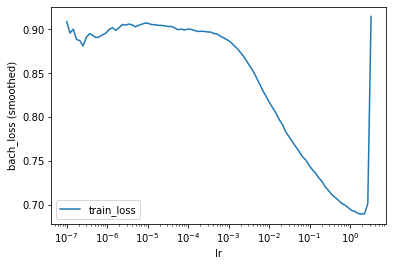

In [273]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=2)
_ = lrfinder.plot()

In [274]:
lrfinder.get_best_lr()

0.1873817422860396

The learning rate is high in general case, so we decrease it to 0.01

In [275]:
model.optimizer.set_lr(0.01)

In [276]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [277]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat())

0:	[0s / 0s],		train_loss: 0.8162,	val_loss: 0.6986
1:	[0s / 0s],		train_loss: 0.5567,	val_loss: 0.6132
2:	[0s / 0s],		train_loss: 0.5601,	val_loss: 0.5730
3:	[0s / 0s],		train_loss: 0.5794,	val_loss: 0.5662
4:	[0s / 0s],		train_loss: 0.6101,	val_loss: 0.5581
5:	[0s / 0s],		train_loss: 0.5485,	val_loss: 0.5599
6:	[0s / 0s],		train_loss: 0.5421,	val_loss: 0.5653
7:	[0s / 0s],		train_loss: 0.5135,	val_loss: 0.5746
8:	[0s / 0s],		train_loss: 0.5095,	val_loss: 0.5643
9:	[0s / 0s],		train_loss: 0.5244,	val_loss: 0.5704
10:	[0s / 0s],		train_loss: 0.5356,	val_loss: 0.5544
11:	[0s / 0s],		train_loss: 0.4923,	val_loss: 0.5693
12:	[0s / 0s],		train_loss: 0.5241,	val_loss: 0.5655
13:	[0s / 0s],		train_loss: 0.5586,	val_loss: 0.5622
14:	[0s / 0s],		train_loss: 0.5091,	val_loss: 0.5725
15:	[0s / 0s],		train_loss: 0.5090,	val_loss: 0.5555
16:	[0s / 0s],		train_loss: 0.5314,	val_loss: 0.5496
17:	[0s / 0s],		train_loss: 0.5417,	val_loss: 0.5581
18:	[0s / 0s],		train_loss: 0.5163,	val_loss: 0.5655
19:

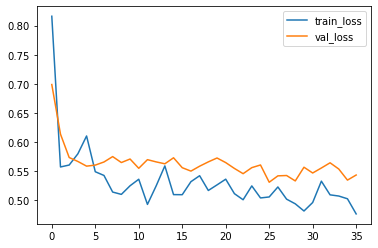

In [278]:
_ = log.plot()

In [279]:
model.partial_log_likelihood(*val).mean() #partial log-likelihood

-5.827738285064697

# Prediction
For evaluation we first need to obtain survival estimates for the test set. This can be done with model.predict_surv which returns an array of survival estimates, or with model.predict_surv_df which returns the survival estimates as a dataframe.

However, as Cox-Time is semi-parametric, we first need to get the non-parametric baseline hazard estimates with compute_baseline_hazards.

Note that for large datasets the sample argument can be used to estimate the baseline hazard on a subset.

In [280]:
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)

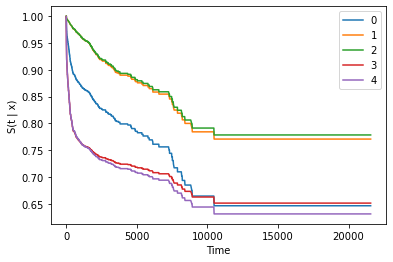

In [281]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

# Evaluation
We can use the EvalSurv class for evaluation the concordance, brier score and binomial log-likelihood. Setting censor_surv='km' means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [282]:
ev = EvalSurv(surv, Time_test, Cens_test, censor_surv='km')

Measure of goodness of fit for binary outcomes in a logistic regression model.  
A value below 0.5 indicates a very poor model.  
A value of 0.5 means that the model is no better than predicting an outcome than random chance.  
Values over 0.7 indicate a good model.

In [283]:
ev.concordance_td()

0.7440946773999759

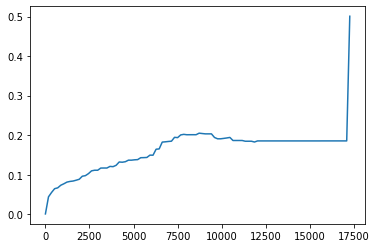

In [284]:
time_grid = np.linspace(Time_test.min(), Time_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

 The Brier score is used to evaluate the accuracy of a predicted survival function at a given time t

In [285]:
ev.integrated_brier_score(time_grid) #brier_score

0.16102695883630289

In [286]:
ev.integrated_nbll(time_grid) #binomial log-likelihood

0.49173145783824523

In [287]:
surv

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0.110364,0.999707,0.999953,0.999955,0.999164,0.999159,0.998411,0.999950,0.999433,0.998917,0.999946,...,0.999959,0.999962,0.999957,0.999954,0.999713,0.999848,0.999851,0.999955,0.999355,0.999957
0.124476,0.999415,0.999907,0.999910,0.998327,0.998317,0.996822,0.999899,0.998865,0.997833,0.999893,...,0.999919,0.999924,0.999914,0.999908,0.999426,0.999696,0.999701,0.999910,0.998710,0.999913
0.181803,0.999415,0.999907,0.999910,0.998327,0.998317,0.996822,0.999899,0.998865,0.997833,0.999893,...,0.999919,0.999924,0.999914,0.999908,0.999426,0.999696,0.999701,0.999910,0.998710,0.999913
0.345582,0.999121,0.999860,0.999864,0.997490,0.997475,0.995233,0.999848,0.998297,0.996749,0.999839,...,0.999878,0.999885,0.999871,0.999862,0.999139,0.999544,0.999551,0.999865,0.998064,0.999869
0.395443,0.998827,0.999813,0.999819,0.996652,0.996632,0.993643,0.999798,0.997728,0.995663,0.999785,...,0.999837,0.999847,0.999828,0.999815,0.998851,0.999391,0.999401,0.999820,0.997417,0.999826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15696.756835,0.646134,0.770628,0.778318,0.651071,0.630895,0.585043,0.750770,0.602565,0.598410,0.767632,...,0.760393,0.796255,0.755126,0.764852,0.735163,0.763576,0.691653,0.762848,0.611008,0.797744
15733.923049,0.646134,0.770628,0.778318,0.651071,0.630895,0.585043,0.750770,0.602565,0.598410,0.767632,...,0.760393,0.796255,0.755126,0.764852,0.735163,0.763576,0.691653,0.762848,0.611008,0.797744
16098.609321,0.646134,0.770628,0.778318,0.651071,0.630895,0.585043,0.750770,0.602565,0.598410,0.767632,...,0.760393,0.796255,0.755126,0.764852,0.735163,0.763576,0.691653,0.762848,0.611008,0.797744
16763.724360,0.646134,0.770628,0.778318,0.651071,0.630895,0.585043,0.750770,0.602565,0.598410,0.767632,...,0.760393,0.796255,0.755126,0.764852,0.735163,0.763576,0.691653,0.762848,0.611008,0.797744


In [288]:
surv.iloc[567,:]

0      0.914023
1      0.983880
2      0.984387
3      0.815338
4      0.815931
         ...   
995    0.954465
996    0.950886
997    0.984196
998    0.848738
999    0.984790
Name: 301.39763647270183, Length: 1000, dtype: float64

# Survival model

In [289]:
import copy
df_train = pd.read_excel("SimData_WList_Ver2.0.xls", index_col = False, header=0)
le = LabelEncoder() 
df_train["Gender"] = le.fit_transform(df_train["Gender"])
df_train["Bloodtype"] = le.fit_transform(df_train["Bloodtype"])
df_train["Inpt_attx"] = le.fit_transform(df_train["Inpt_attx"])

feature_df_train = copy.deepcopy(df_train)

In [290]:
def trans_y(y):
    mytype=np.dtype([('Status', '?'), ('Survival_in_days', '<f8')])
    data_y = np.zeros(len(y[0]),dtype=mytype)
    for i in range(len(y[0])):
        data_y[i][0] = y[1][i]
        data_y[i][1] = y[0][i]
    return data_y

In [291]:
new_y_test = trans_y(y_test)
new_y_train = trans_y(y_train)

In [292]:
import numpy as np
from sksurv.metrics import concordance_index_censored
from sksurv.nonparametric import kaplan_meier_estimator
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(x_train, new_y_train)

CoxPHSurvivalAnalysis()

In [295]:
from sksurv.metrics import concordance_index_censored # c index

prediction = estimator.predict(x_test)
result = concordance_index_censored(new_y_test["Status"], new_y_test["Survival_in_days"], prediction)
result[0]

0.7426528895830831

Random Survival Forest & CoxPH & Penalized CoxPH & Gradient Boost model

In [299]:
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
rsf_gbsg = RandomSurvivalForest(max_depth=2, random_state=1)
rsf_gbsg.fit(x_train, new_y_train)

est_cph_tree = GradientBoostingSurvivalAnalysis(
    n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0
)
est_cph_tree.fit(x_train, new_y_train)

cph_gbsg = CoxnetSurvivalAnalysis(l1_ratio=0.99, fit_baseline_model=True)
cph_gbsg.fit(x_train, new_y_train)

CoxnetSurvivalAnalysis(fit_baseline_model=True, l1_ratio=0.99)

In [310]:
score_cindex = pd.Series(
    [
        estimator.score(x_test, new_y_test),
        rsf_gbsg.score(x_test, new_y_test),
        cph_gbsg.score(x_test, new_y_test),
        est_cph_tree.score(x_test, new_y_test),
        0.5,
    ],
    index=['CPH',"RSF", "CPHP",'GBS',"Random"], name="c-index",
)

score_cindex.round(5)

CPH       0.74265
RSF       0.73847
CPHP      0.74353
GBS       0.74393
Random    0.50000
Name: c-index, dtype: float64

# Gradient Boost

In [306]:
# Let’s see how the test performance changes with the ensemble size (n_estimators).
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(
    learning_rate=1.0, max_depth=1, random_state=0
)
for i in range(1, 31):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(x_train, new_y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(x_test, new_y_test)

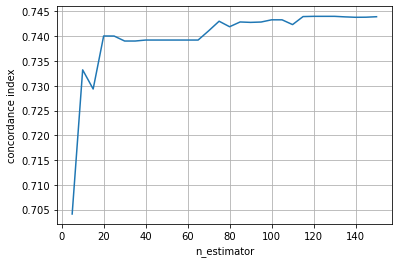

In [307]:
x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)